# Challenge 2: Kernel Ridge Regression and Kernel PCA

<a target="_blank" href="https://colab.research.google.com/github/LucaPennella/Intro_to_ML_23-24/blob/main/challenges/challenge_two.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

The challenge is to show why it is better (or not) to use kernelised methods in two toy data sets, and find out which kernel is the most suitable for each.    
There are two main tasks:
1. Ridge Regression vs Kernel Ridge Regression
2. PCA vs Kernel PCA

Tip: *for the whole challenge, you can use ```sklearn```.*

## 1. Ridge Regression
Using the training and test data sets created in the following cell, what you have to do is:
* Fit a linear Ridge Regression model;
* Fit a Kernel Ridge Regression model with a Gaussian kernel and one with a Polynomial kernel. Through a grid search, see how different values for gamma for the Gaussian, and different degrees and values for the regularisation term for the Polynomial, change the line that gets fitted by the model.   
Lastly, fit one last KRR with the best kernel and best parameters that you found (the ones that minimise the test error).

For each subtask, calculate the RMSE on the test data set and plot a visual representation of each fitted line, also when trying different values for the parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC

# create training dataset
train_points = 20
eps = np.random.normal(0, 1, train_points)

X_train = np.linspace(-5, 5, train_points)
y_train = (X_train+4) * (X_train+1) * (np.cos(X_train)-1) * (X_train-3) + eps

X_train = X_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

# create testing data set
test_points = 1000

X_test = np.linspace(-5, 5, test_points)
y_test = (X_test+4) * (X_test+1) * (np.cos(X_test)-1) * (X_test-3)

X_test = X_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

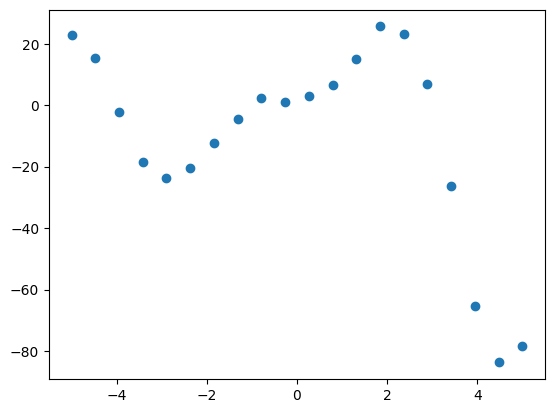

In [2]:
plt.plot(X_train,y_train, 'o')

In [3]:
X_train[:5]

array([[-5.        ],
       [-4.47368421],
       [-3.94736842],
       [-3.42105263],
       [-2.89473684]])

In [4]:
X_train_bias = np.hstack((X_train, np.ones((X_train.shape[0], 1))))

In [5]:
X_train_bias[:5]

array([[-5.        ,  1.        ],
       [-4.47368421,  1.        ],
       [-3.94736842,  1.        ],
       [-3.42105263,  1.        ],
       [-2.89473684,  1.        ]])

In [6]:
lam = 1

xTx = np.dot(X_train_bias.T, X_train_bias)
k = lam * np.eye(X_train_bias.shape[1])
w_ridge_no_inv = np.linalg.inv(xTx + k).dot(X_train_bias.T).dot(y_train)

y_pred = X_train_bias[:,0]*w_ridge_no_inv[0] + w_ridge_no_inv[1]

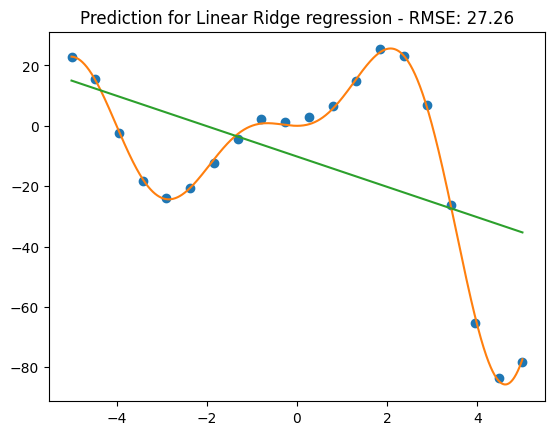

In [7]:
rmse = root_mean_squared_error(y_train, y_pred)
plt.plot(X_train_bias[:,0], y_train, 'o', label="Training data")
plt.plot(X_test[:,0], y_test, '-', label="Testing data")
plt.plot(X_train_bias[:,0], y_pred, '-', label="Prediction")
plt.title(f"Prediction for Linear Ridge regression - RMSE: {rmse:.2f}")
plt.show()

In [8]:
def kernelFunc(x1, x2, kernel_type, param = 2):
    """
    args:
        x_1: first component, array
        x_2: second component, array
        kernel_type: used to specify which kernel to use, string
        param: p parameter
    
    output:
        Value of the kernel 
    """
    if kernel_type == "poly":
        if param <= 0:
            raise ValueError("Invalid exponent for the polynomial")
        return (np.dot(x1,x2.T) + 1)**param
    
    if kernel_type == "Gauss":
        if param == 0:
            raise ValueError("Invalid exponent for the Gauss")
        diff = x1 - x2
        return np.exp(-np.dot(diff, diff) / (2 * param**2))
    
    if kernel_type == "Linear":
        return np.dot(x1.T,x2)

In [9]:
def KRRS(X_train, y_train, X_test, kernel_type, param, lam):
    """
    args:
        X_train: train set, matrix
        y_train: labels for training, array
        X_test: test set, matrix
        kernel_type: used to specify which kernel to use, string
        param: p parameter
        lam: lambda parameter used in RR
    
    output:
        Predictions for the test set
    Non utilizzare np.linalg.inv, risolverlo come sistema lineare
    """


    # YOUR CODE
    if kernel_type == "poly":
        K = (np.dot(X_train,X_train.T) + 1)**param
    elif kernel_type == "Gauss":
        X_norm = np.sum(X_train**2, axis=1).reshape(-1, 1)
        K = np.exp(-(X_norm - 2 * np.dot(X_train, X_train.T) + X_norm.T) / (2 * param**2))
    elif kernel_type == "Linear":
        K = np.dot(X_train,X_train.T)
    else:
        raise ValueError(f"Unknown kernel type: {kernel_type}")
    
    a = np.linalg.solve(K + lam * np.eye(K.shape[0]), y_train)

    y_pred = np.zeros(X_test.shape[0])

    for i, x_p in enumerate(X_test):
        k = np.zeros(X_train.shape[0])
        for j, _ in enumerate(k):
            k[j] = kernelFunc(x_p, X_train[j,:], kernel_type=kernel_type, param=param)
        y_pred[i] = np.dot(a.ravel(),k.ravel())
    return y_pred

In [10]:
param_grid = [0.01, 0.1, 1, 5, 10]
lambda_grid = [0.01, 0.1, 1, 5, 10]
reg_type = ["Gauss", "poly"]

Kernel Type: Gauss


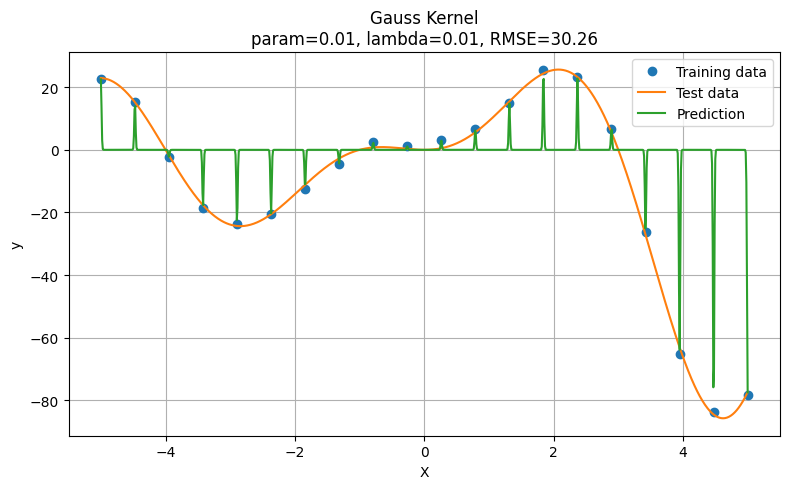

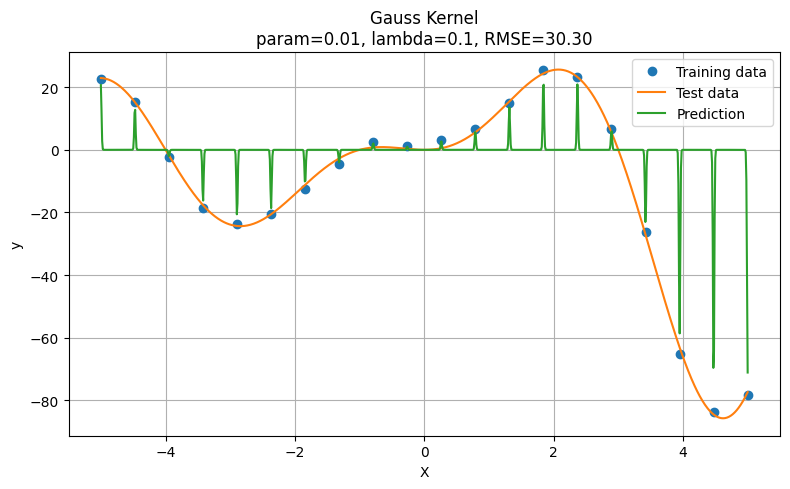

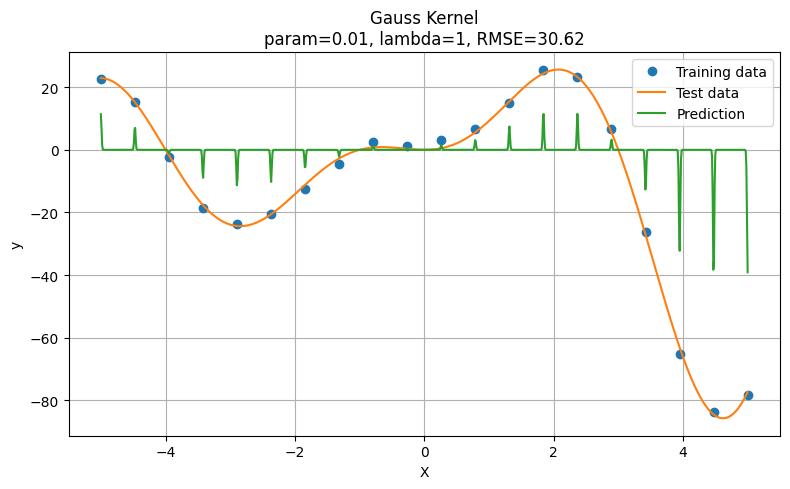

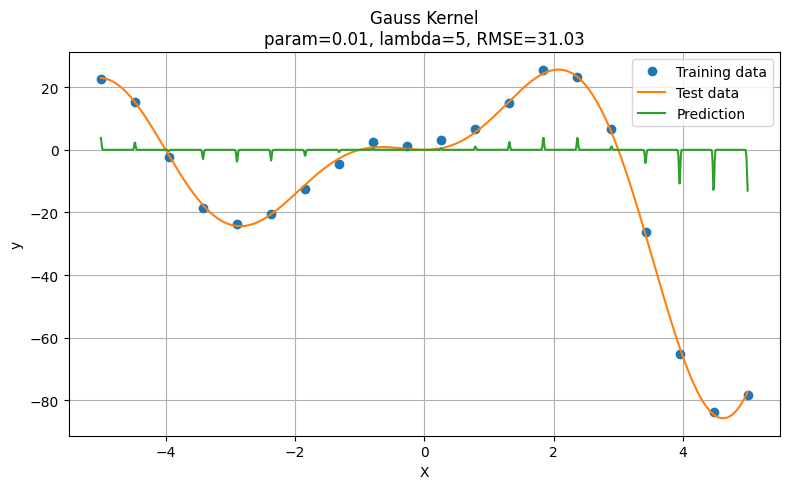

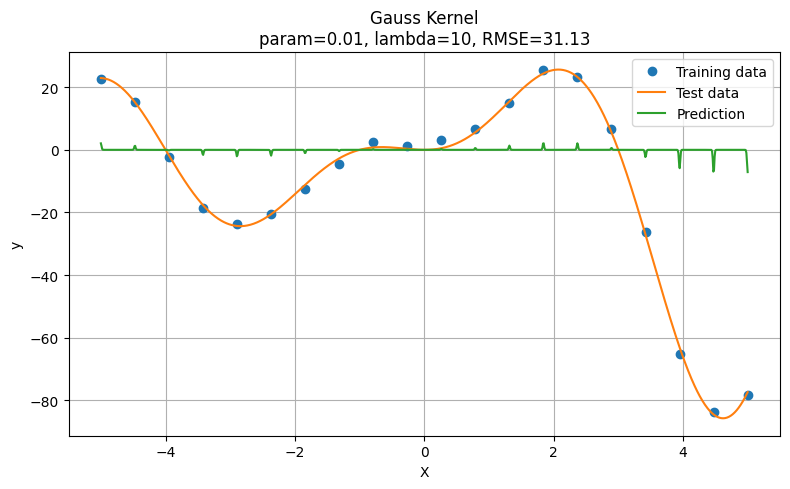

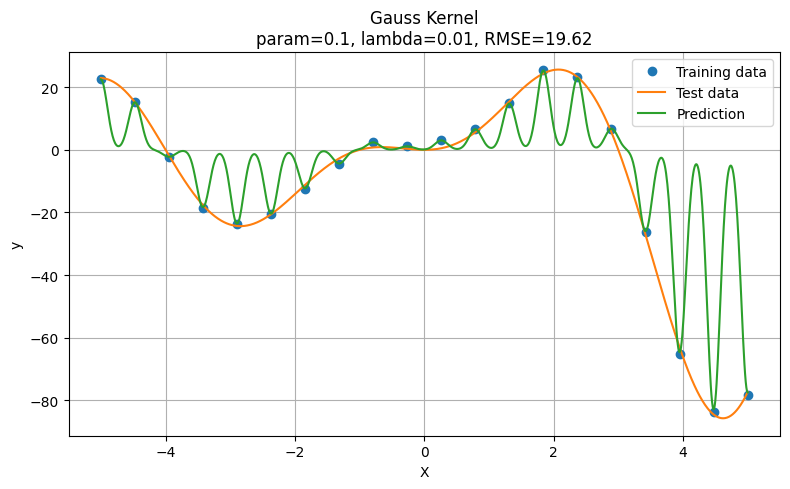

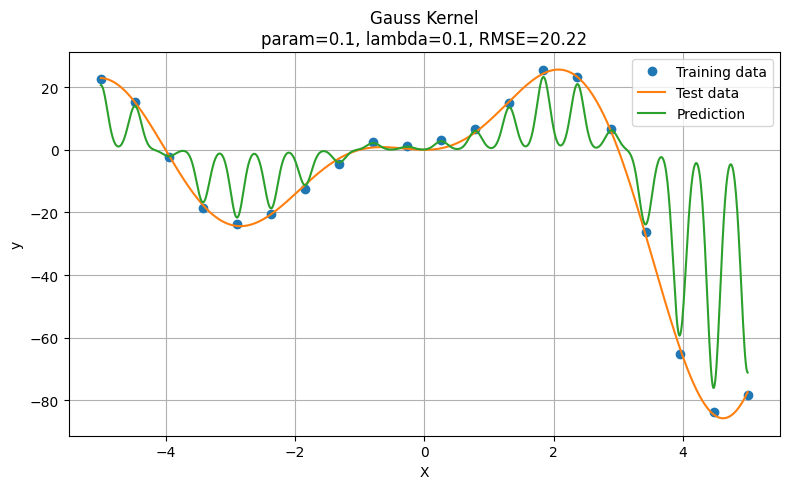

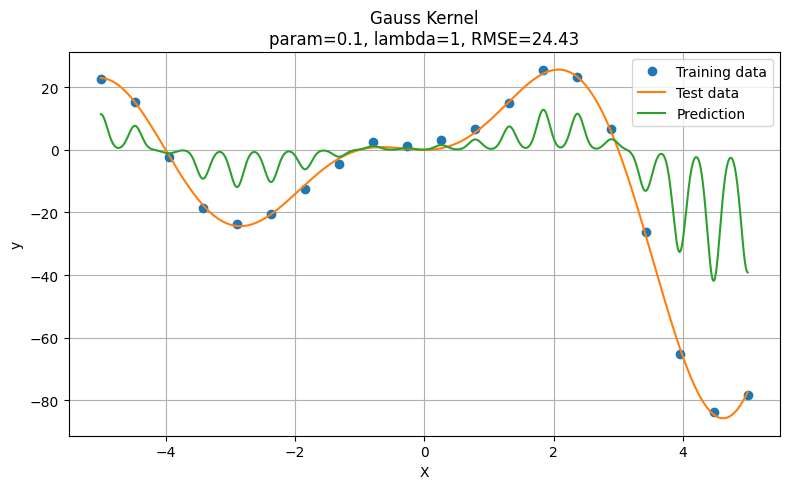

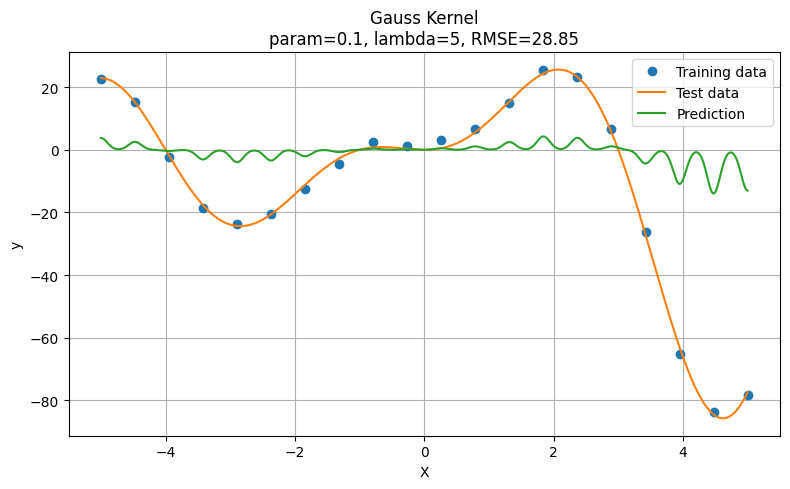

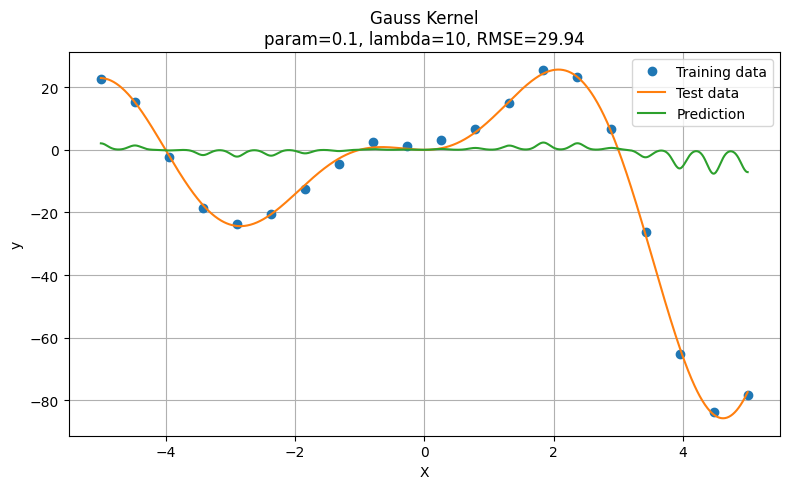

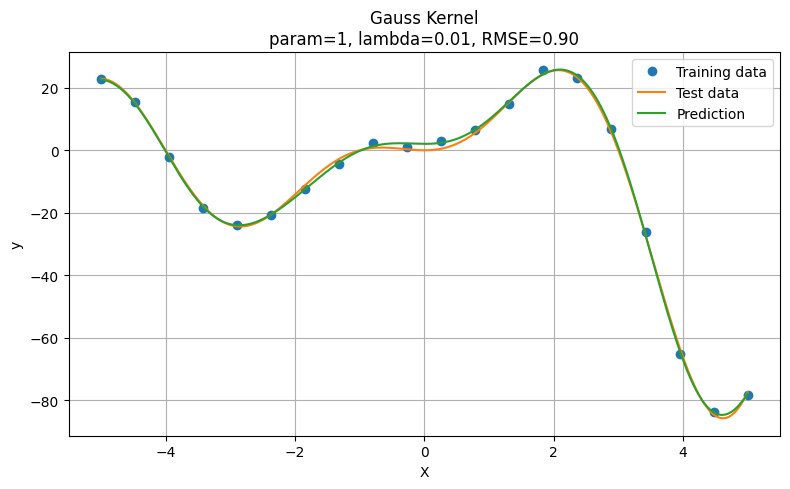

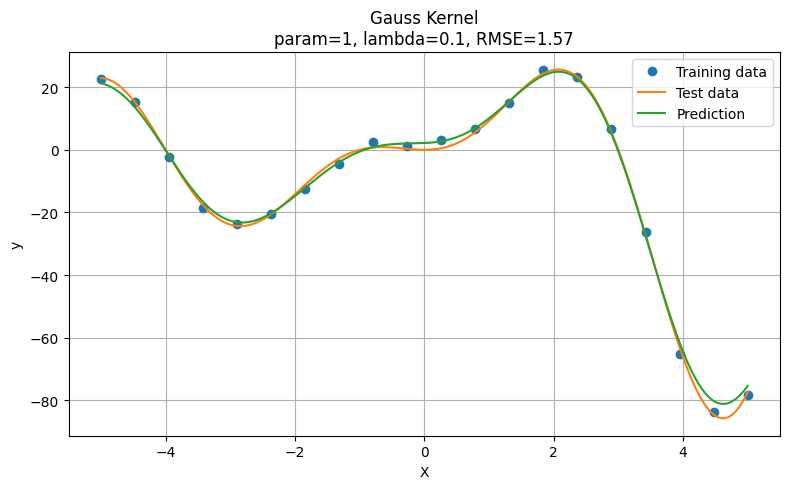

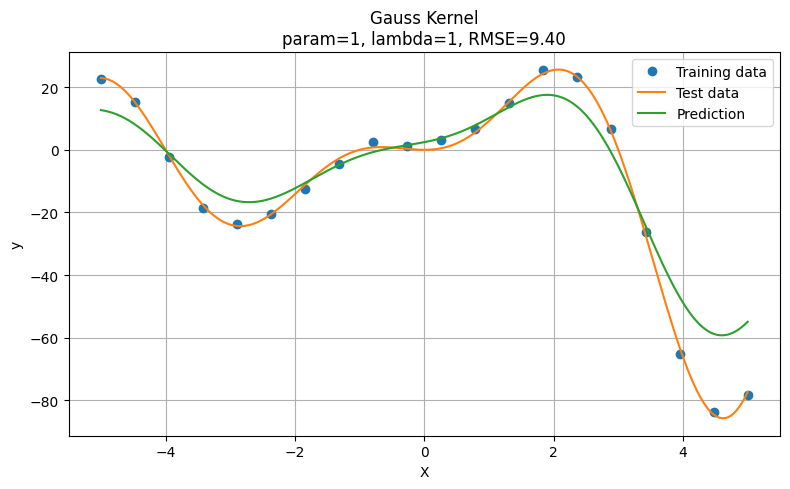

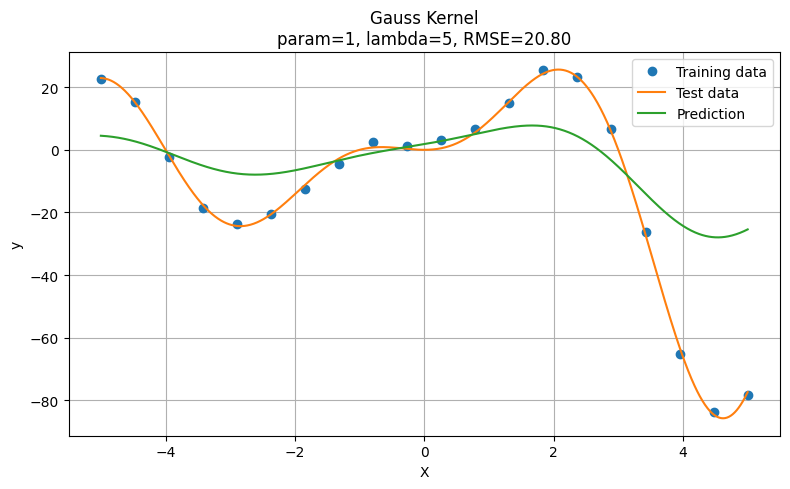

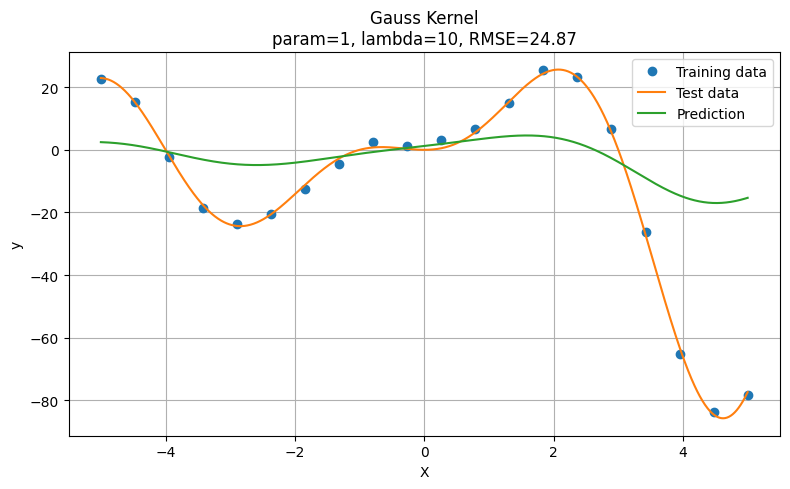

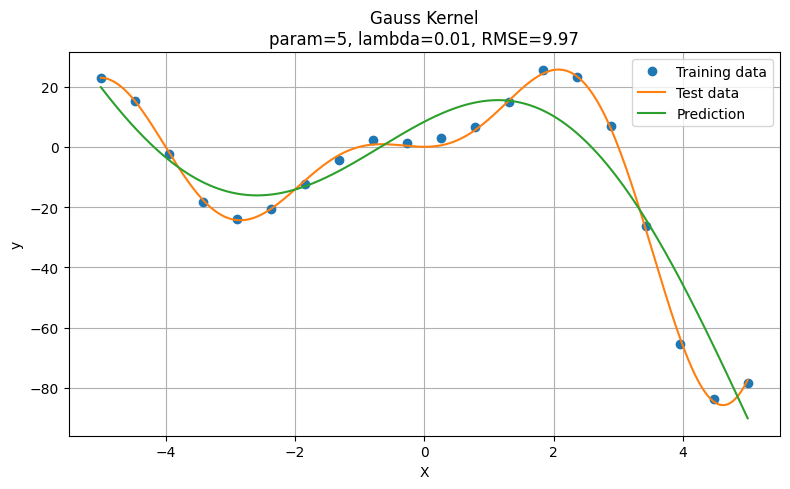

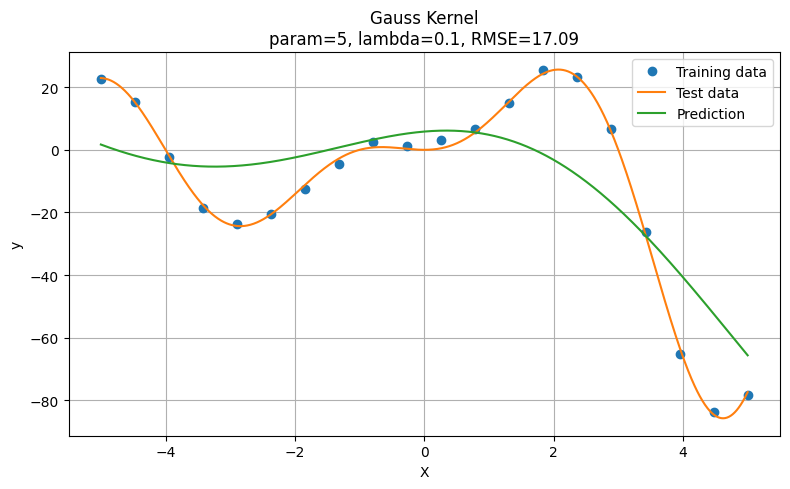

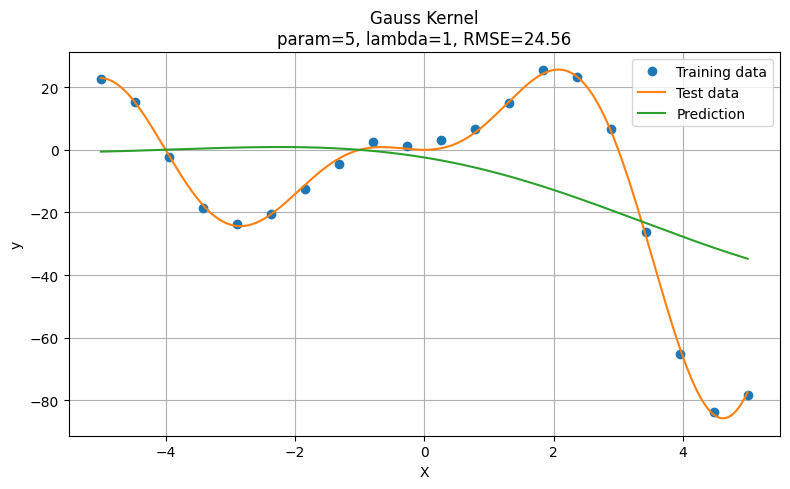

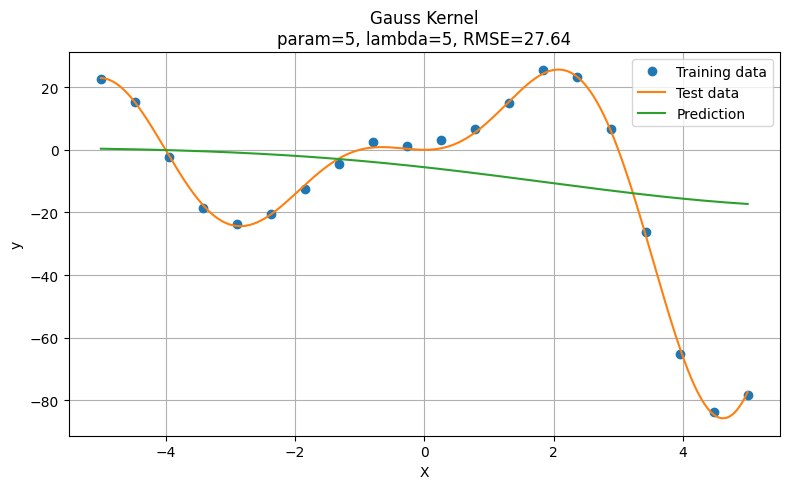

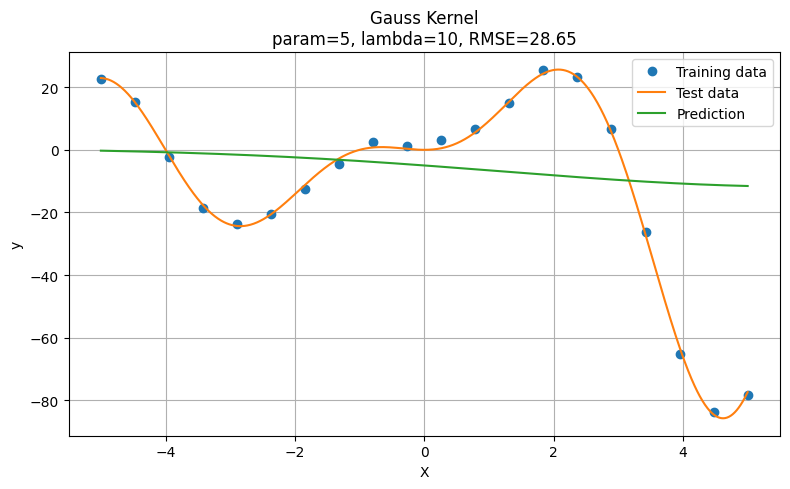

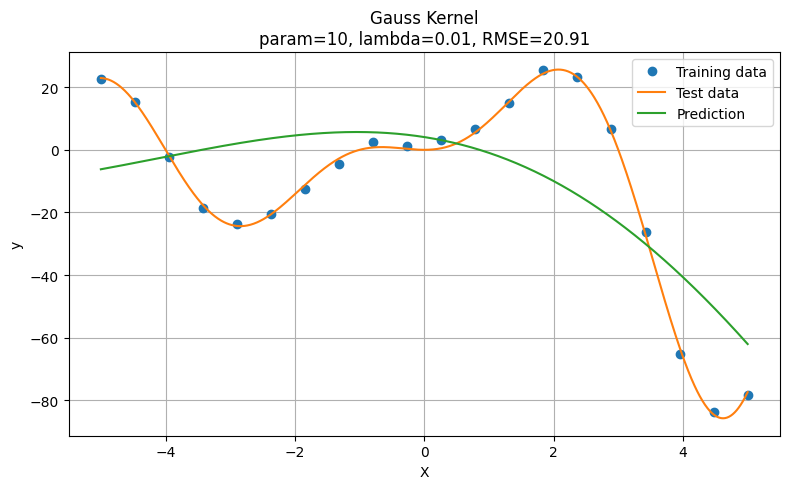

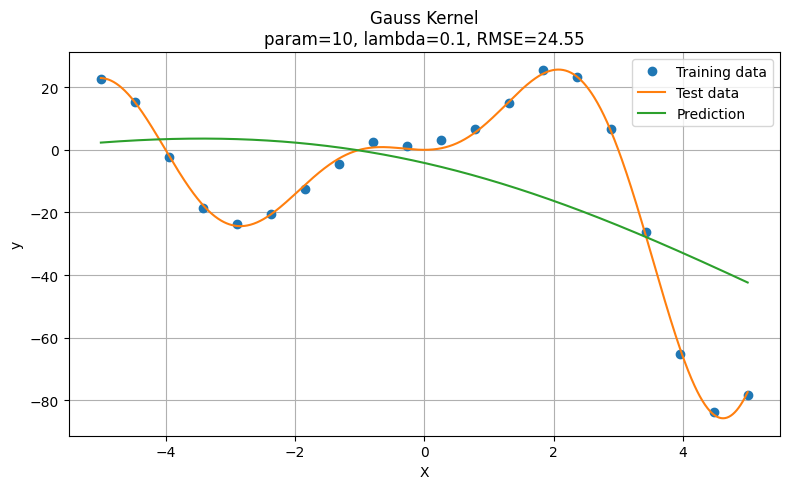

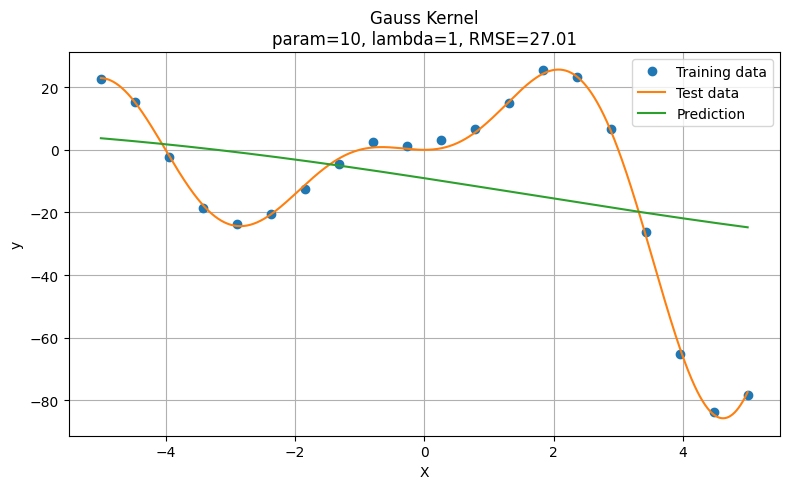

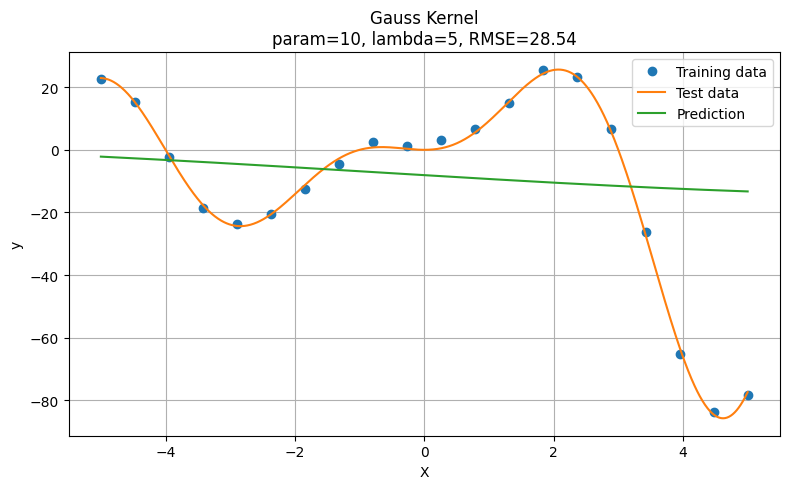

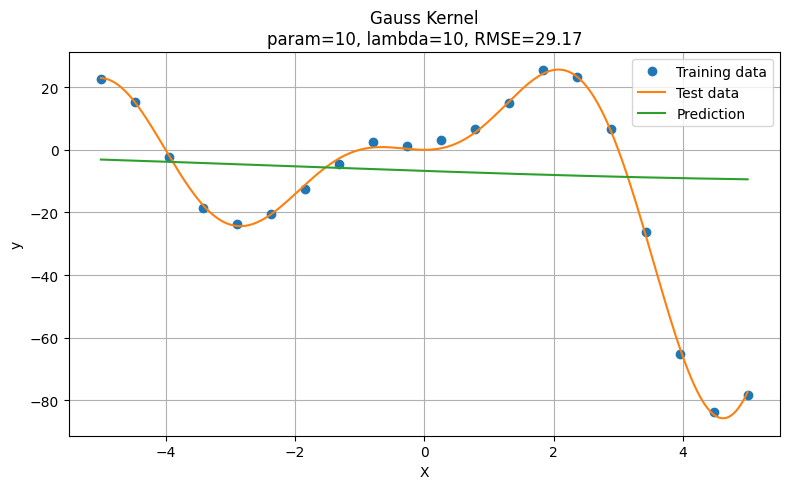

Kernel Type: poly


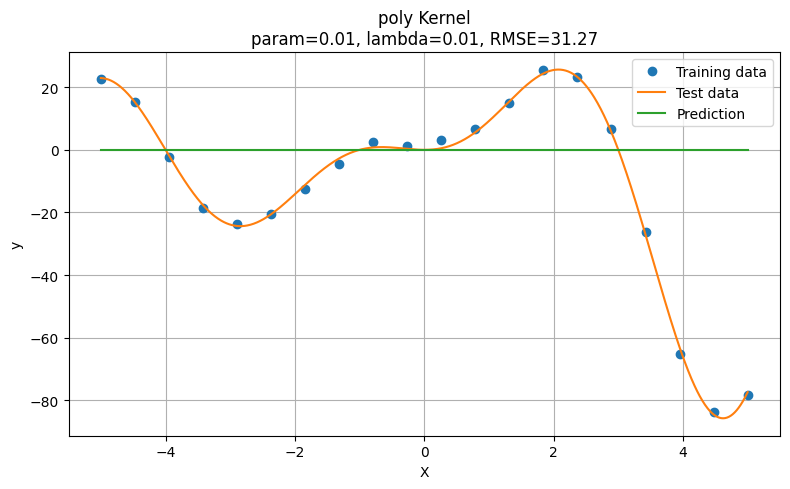

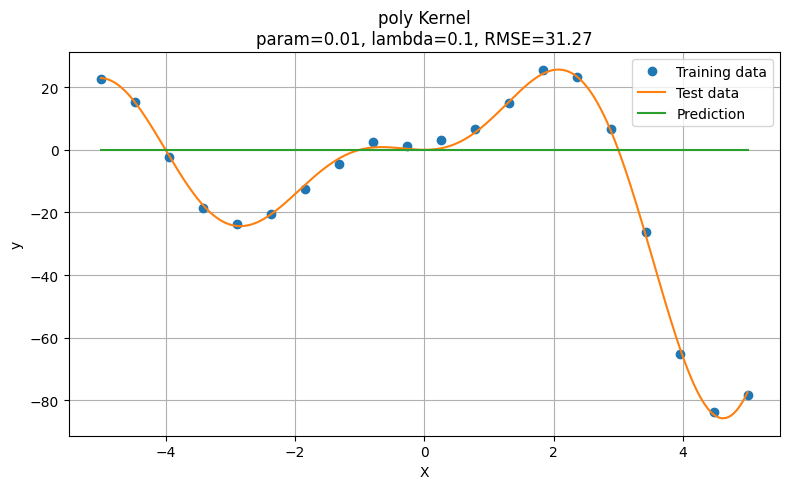

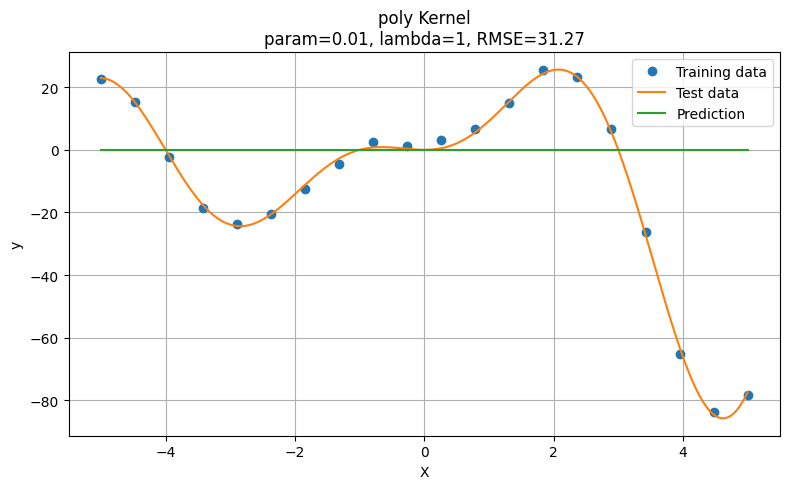

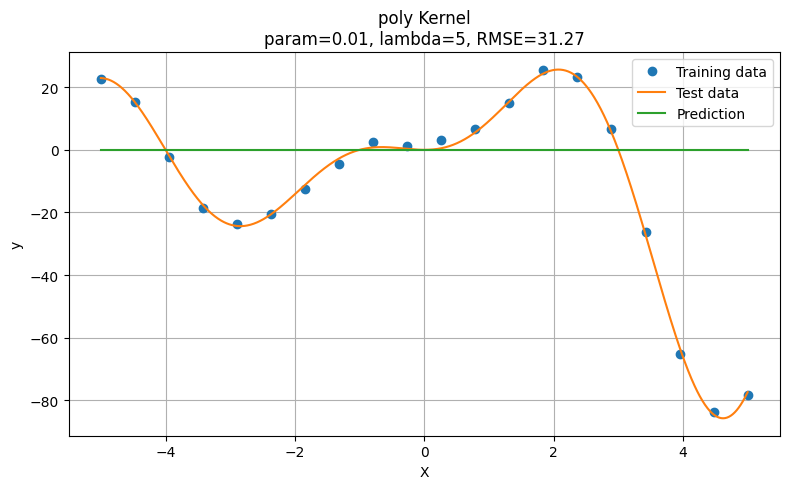

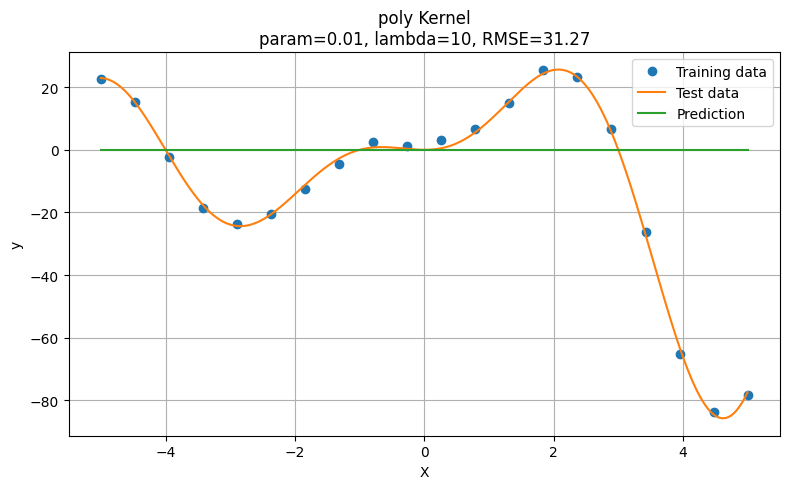

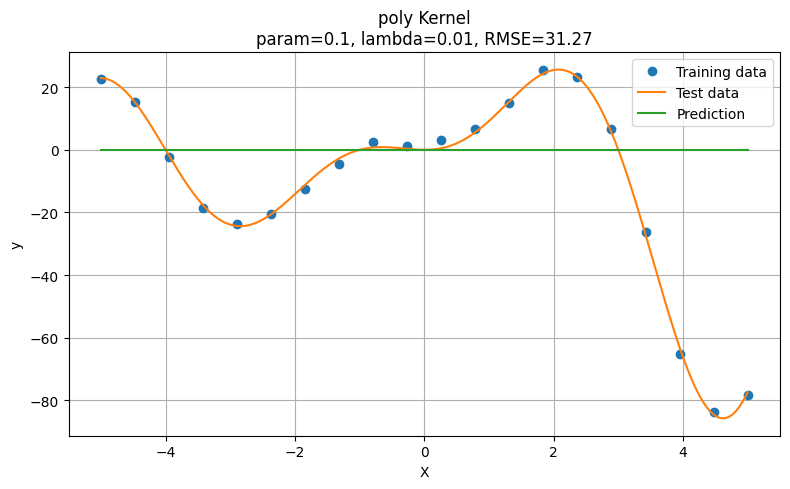

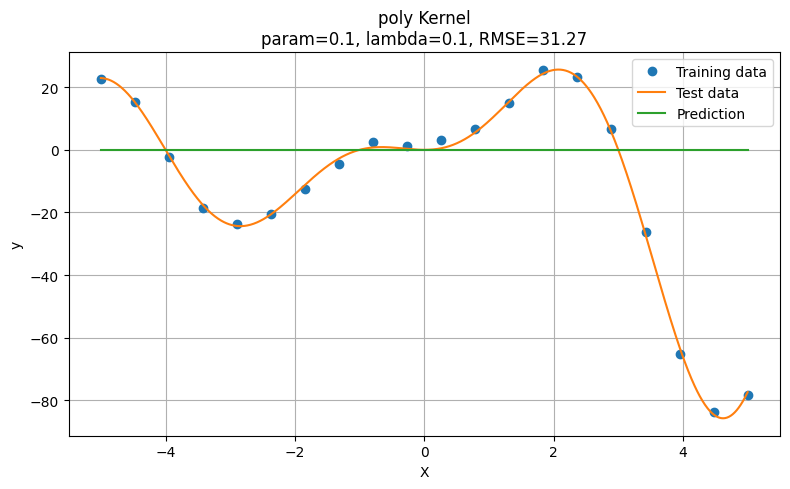

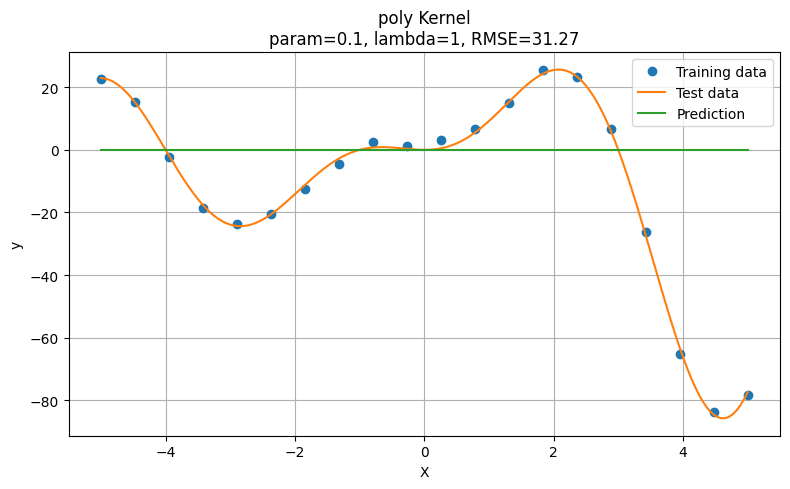

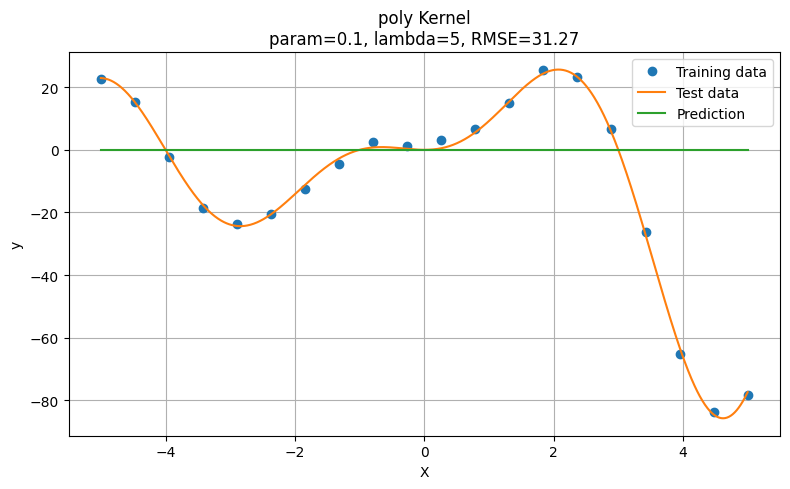

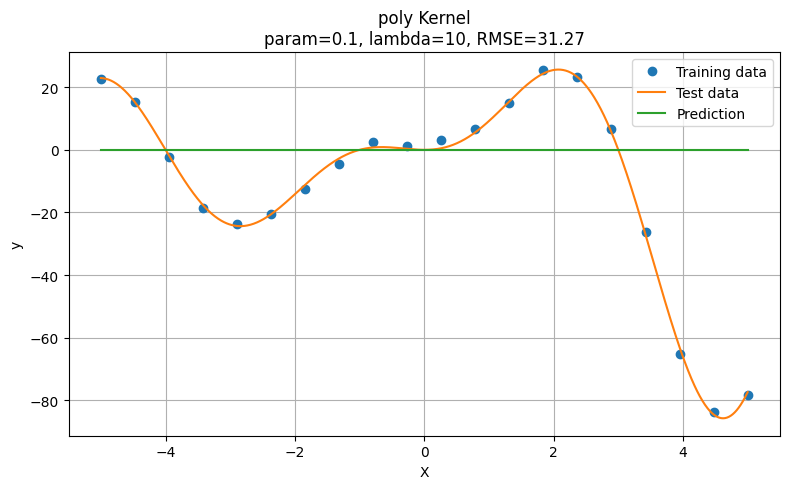

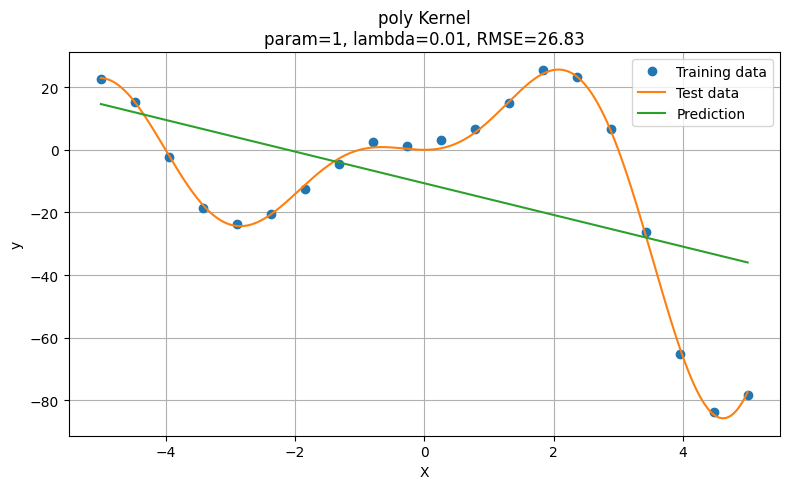

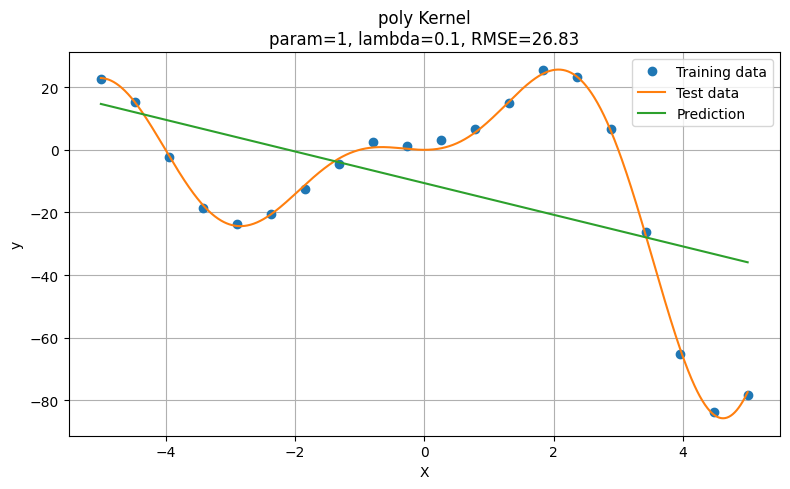

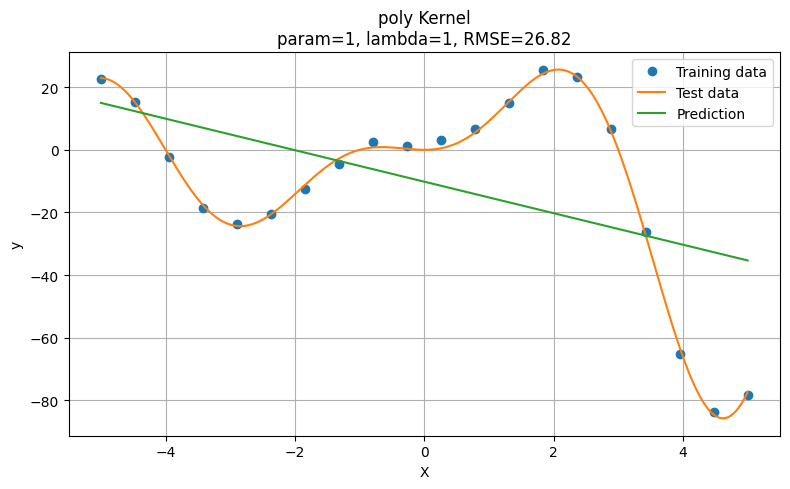

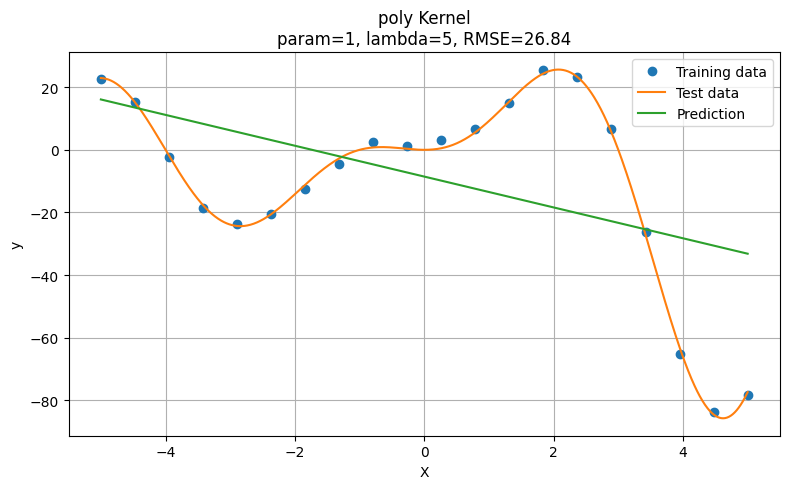

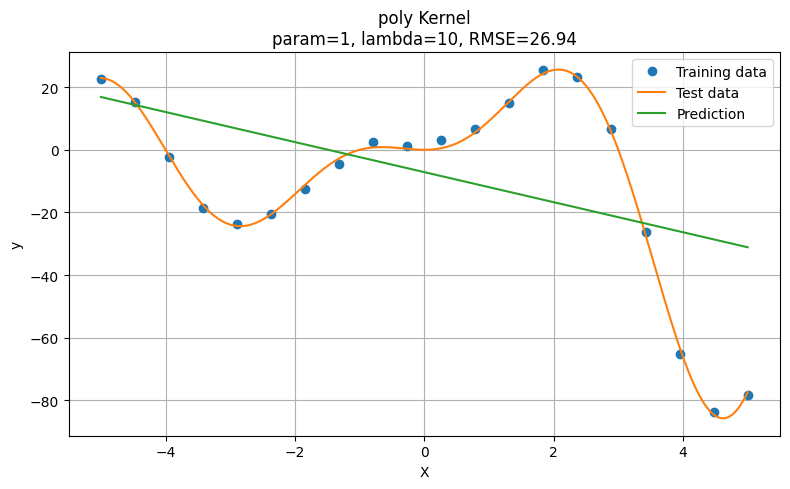

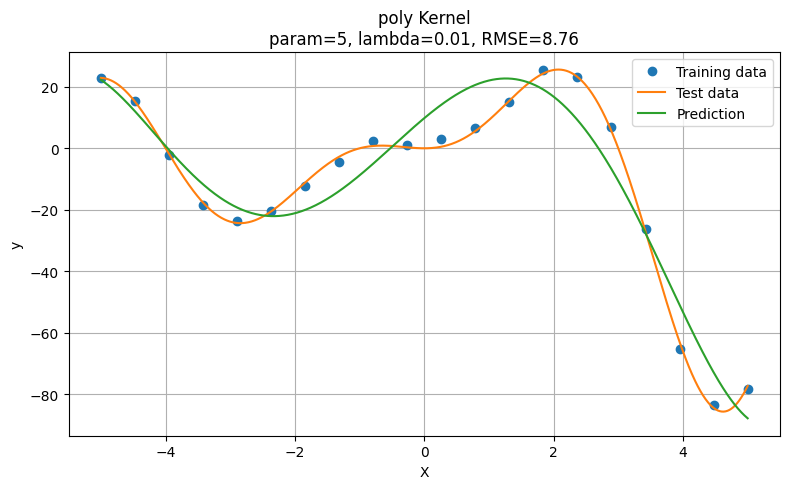

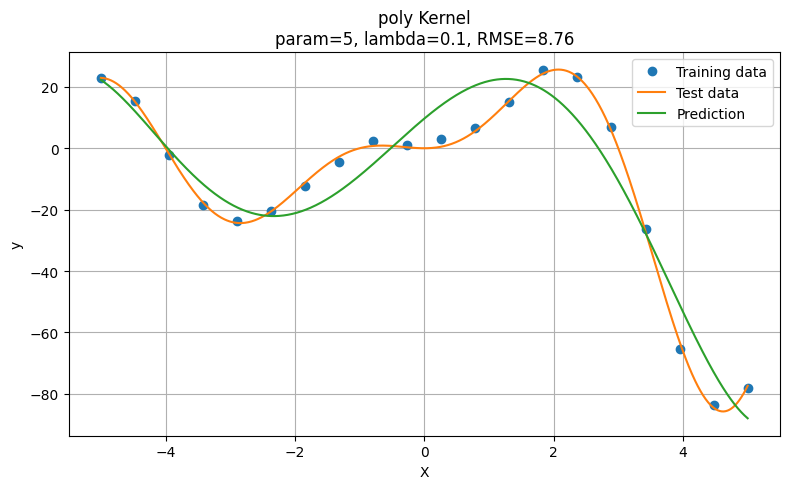

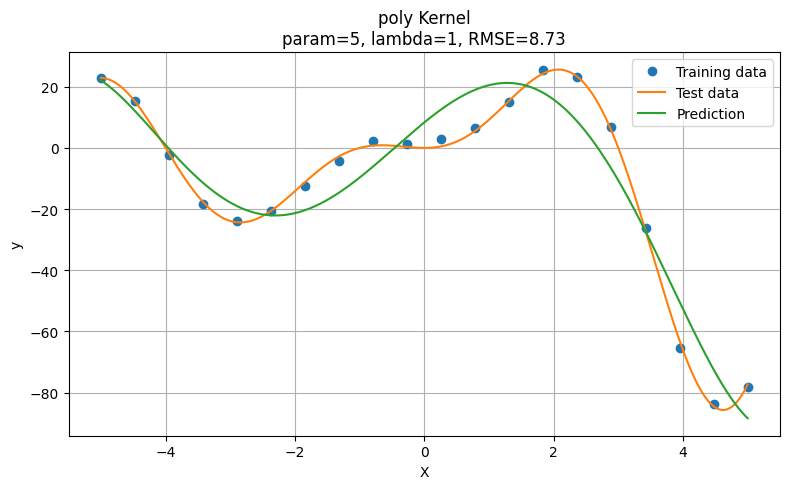

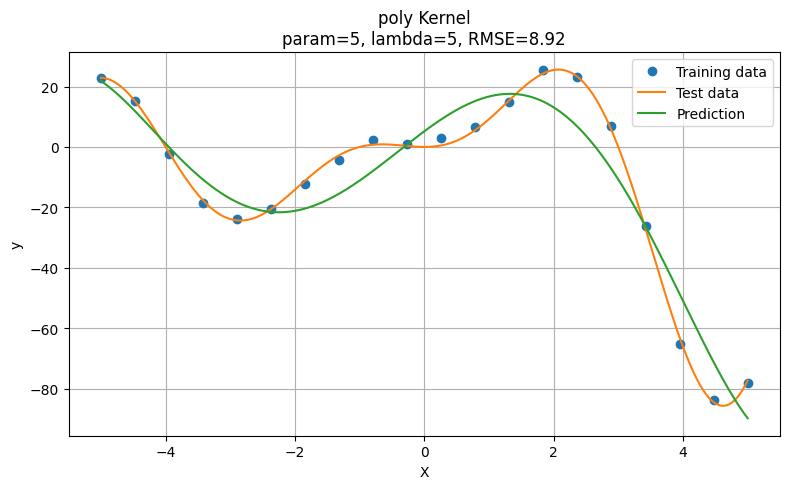

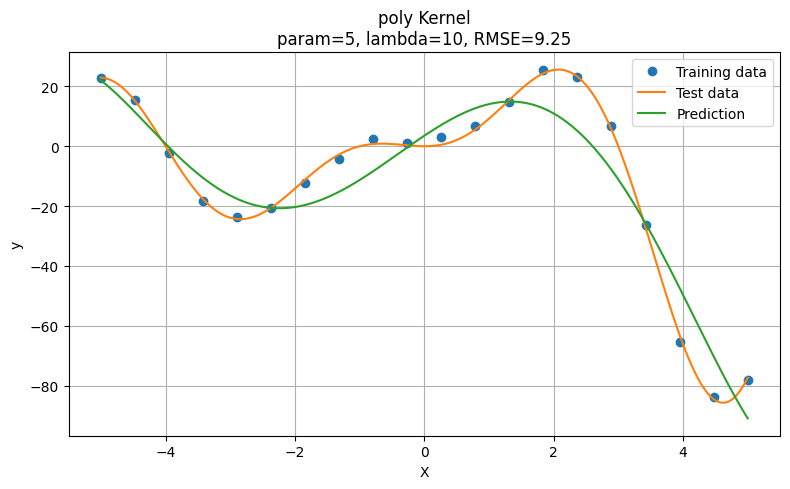

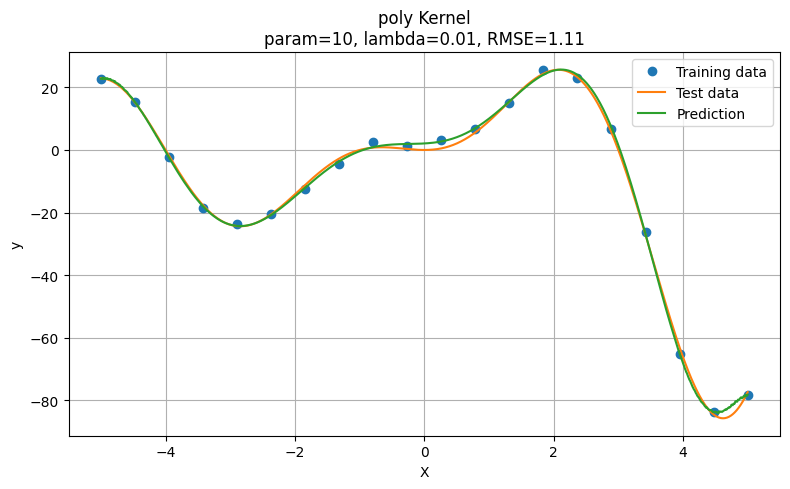

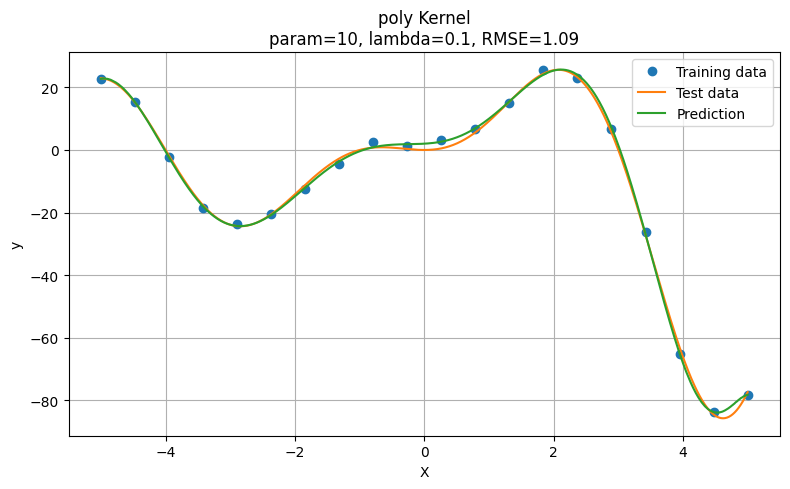

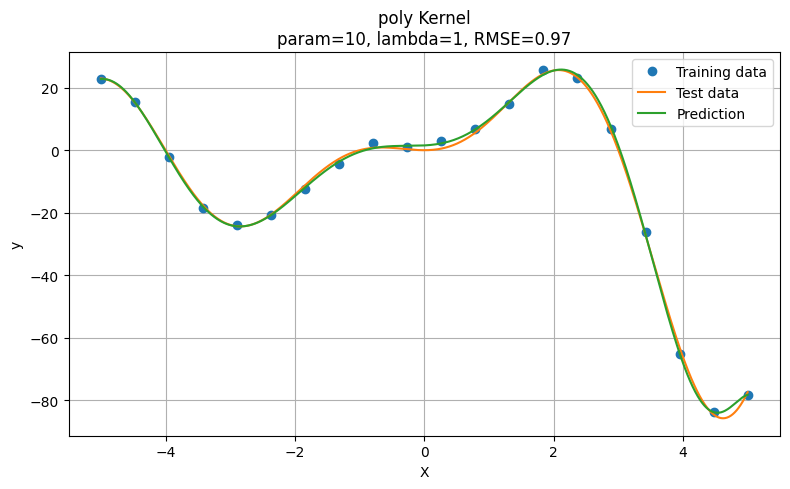

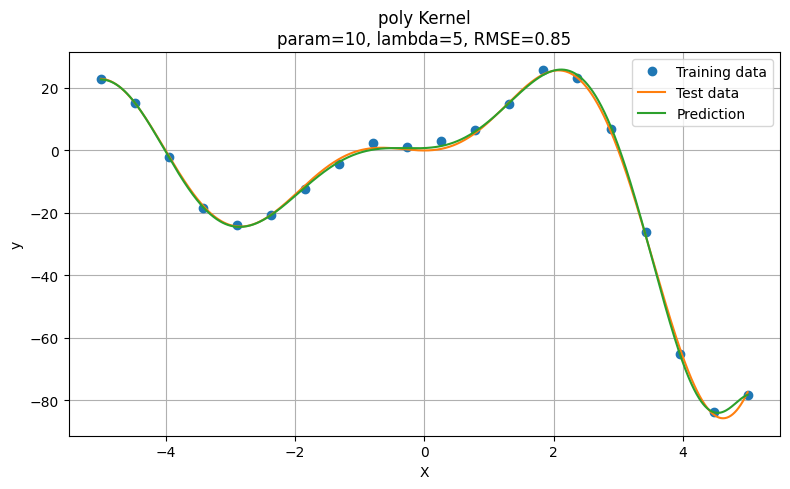

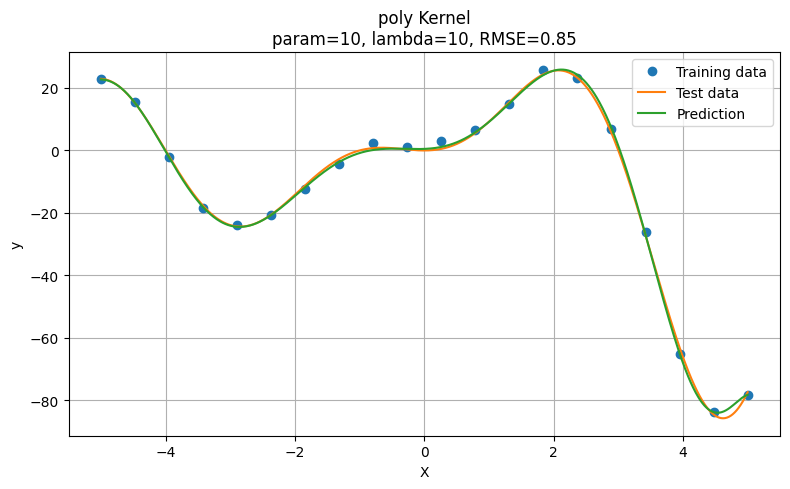

In [11]:
results = []
# Plot RMSE vs param for each lambda, grouped by kernel
for reg in reg_type:
    print(f"Kernel Type: {reg}")
    
    for param in param_grid:
        for lam in lambda_grid:
            # Make prediction
            if reg == "poly" and param < 1:
                y_pred = np.zeros(y_test.shape[0])
            else:
                y_pred = KRRS(X_train, y_train, X_test, kernel_type=reg, param=param, lam=lam)
            rmse = root_mean_squared_error(y_test, y_pred)

            results.append((reg, param, lam, rmse))

            # Plot
            plt.figure(figsize=(8, 5))
            plt.plot(X_train[:, 0], y_train, 'o', label="Training data")
            plt.plot(X_test[:, 0], y_test, '-', label="Test data")
            plt.plot(X_test[:, 0], y_pred, '-', label="Prediction")

            plt.title(f"{reg} Kernel\nparam={param}, lambda={lam}, RMSE={rmse:.2f}")
            plt.xlabel("X")
            plt.ylabel("y")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()



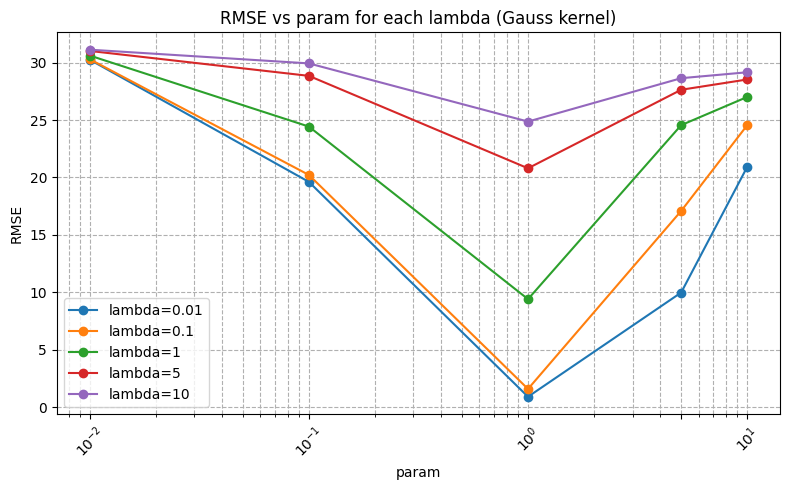

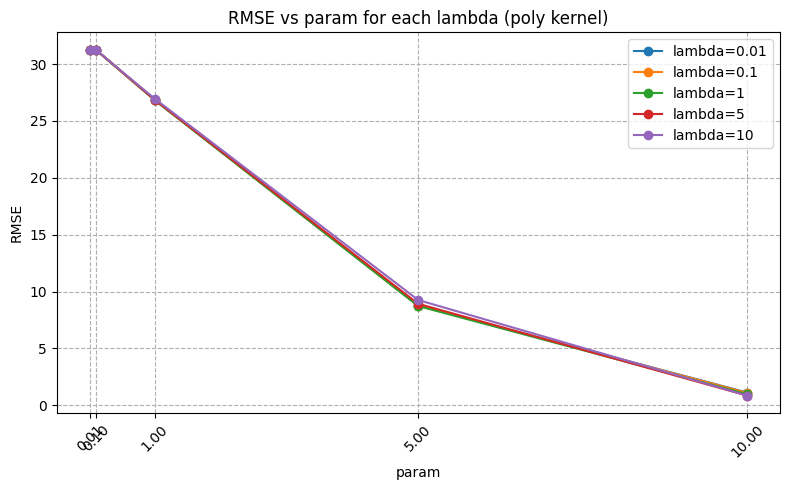

In [12]:
# Plot RMSE vs param for each lambda, grouped by kernel
for reg in reg_type:
    plt.figure(figsize=(8, 5))
    rmse_by_lambda = {lam: [] for lam in lambda_grid}
    for r, param, lam, rmse in results:
        if r == reg:
            rmse_by_lambda[lam].append((param, rmse))
    
    for lam, values in rmse_by_lambda.items():
        values.sort()
        params = [v[0] for v in values]
        rmses = [v[1] for v in values]
        if reg == "poly":
            plt.plot(params, rmses, marker='o', label=f"lambda={lam}")
        else:
            plt.semilogx(params, rmses, marker='o', label=f"lambda={lam}")

    plt.xticks(param_grid, rotation=45)
    plt.xlabel("param")
    plt.ylabel("RMSE")
    plt.title(f"RMSE vs param for each lambda ({reg} kernel)")
    plt.grid(True, which='both', linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [13]:
best = {}

for reg, param, lam, rmse in results:
    if reg not in best:  # First iteration, just set the best_rmse
        best[reg] = {
            "best_param" : param,
            "best_lam" : lam,
            "best_rmse" : rmse
        }

    else:
        # Calculate the difference between the current RMSE and the best RMSE
        diff = best[reg]["best_rmse"] - rmse
        
        # If the current RMSE is better (smaller), calculate the percentile improvement
        if diff > 0:
            percentile_diff = (diff / best[reg]["best_rmse"]) * 100  # Calculate percentage improvement
            
            # If the percentile improvement is greater than 5%, update best_param and best_lam
            if abs(percentile_diff) > 5:  # 5% improvement
                best[reg]["best_rmse"] = rmse
                best[reg]["best_param"] = param
                best[reg]["best_lam"] = lam

print(best)

{'Gauss': {'best_param': 1, 'best_lam': 0.01, 'best_rmse': 0.8956742749356197}, 'poly': {'best_param': 10, 'best_lam': 5, 'best_rmse': 0.8451428243828736}}


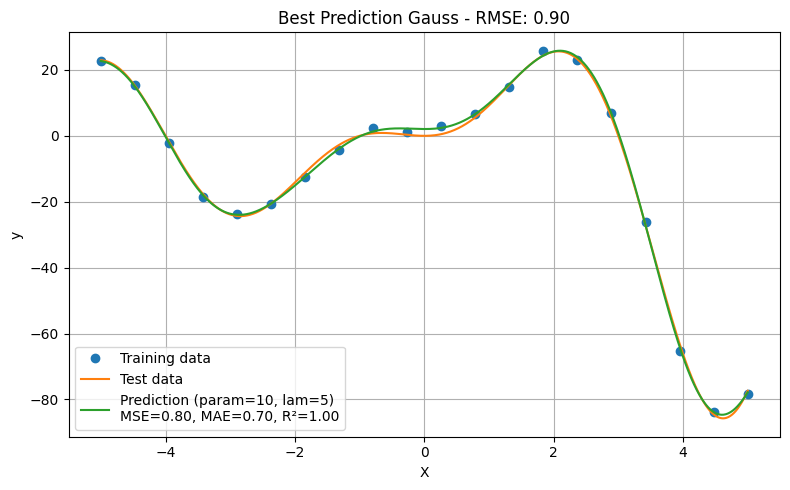

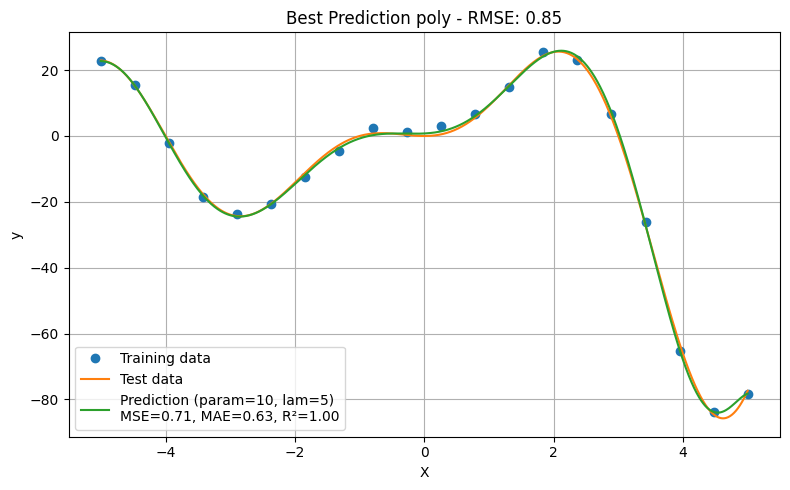

In [14]:
for reg in reg_type:
    y_pred_best = KRRS(X_train, y_train, X_test, kernel_type=reg, param=best[reg]["best_param"], lam=best[reg]["best_lam"])

    mse = mean_squared_error(y_test, y_pred_best)
    mae = mean_absolute_error(y_test, y_pred_best)
    r2 = r2_score(y_test, y_pred_best)

    label = (
    f"Prediction (param={best['poly']['best_param']}, lam={best['poly']['best_lam']})\n"
    f"MSE={mse:.2f}, MAE={mae:.2f}, R²={r2:.2f}"
    )

    plt.figure(figsize=(8, 5))
    plt.plot(X_train[:, 0], y_train, 'o', label="Training data")
    plt.plot(X_test[:, 0], y_test, '-', label="Test data")
    plt.plot(X_test[:, 0], y_pred_best, '-', label=label)
    plt.xlabel("X")
    plt.ylabel("y")
    plt.title(f"Best Prediction {reg} - RMSE: {best[reg]['best_rmse']:.2f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
plt.show()


## 2. PCA
Using the training and test data sets created in the following cell, what you have to do is:
* Fit a PCA model;
* Fit a Kernel PCA model with a kernel of your choice.

For each subtask, plot a visual representation of the projections and verify the accuracy of that kernel on the test data set using SVM.

In [33]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

X, y = make_circles(n_samples=1000, noise=0.15, factor=0.2, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=0)

In [34]:
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA

learn = PCA()

X_train_pca = learn.fit_transform(X_train)
X_test_pca = learn.transform(X_test)


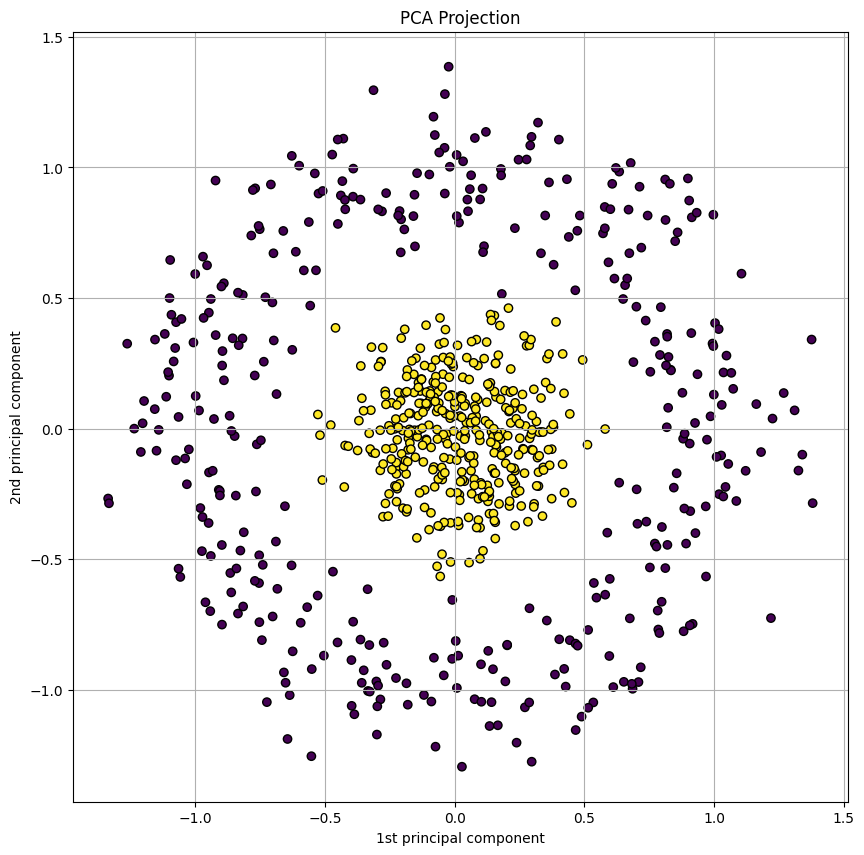

In [35]:
plt.figure(figsize=(10,10))
plt.scatter(X_train_pca[:,0],X_train_pca[:,1], c=y_train, cmap='viridis', edgecolor='k')
plt.title("PCA Projection")
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.grid(True)
plt.show()

In [36]:
clf = SVC(kernel="linear")
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.30      0.45       125
           1       0.58      0.97      0.72       125

    accuracy                           0.63       250
   macro avg       0.74      0.63      0.59       250
weighted avg       0.74      0.63      0.59       250



### KPCA

In [38]:
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=5)

X_train_kpca = kpca.fit_transform(X_train)
X_test_kpca = kpca.transform(X_test)

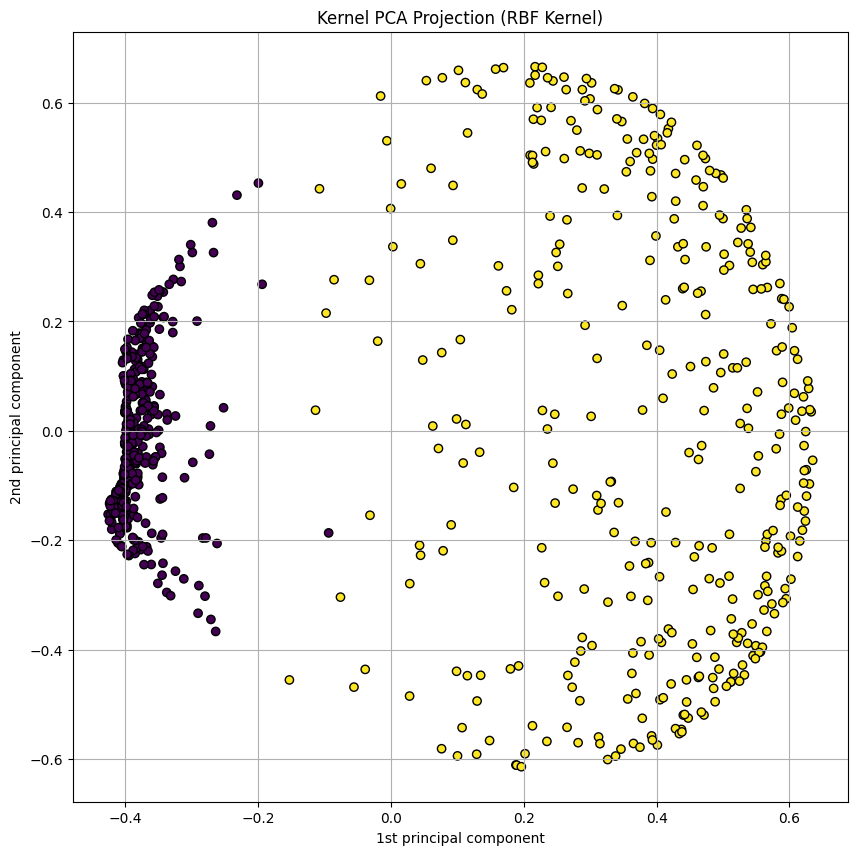

In [39]:
plt.figure(figsize=(10,10))
plt.scatter(X_train_kpca[:, 0], X_train_kpca[:, 1], c=y_train, cmap='viridis', edgecolor='k')
plt.title("Kernel PCA Projection (RBF Kernel)")
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.grid(True)
plt.show()

In [40]:
clf.fit(X_train_kpca, y_train)
y_pred = clf.predict(X_test_kpca)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       125
           1       1.00      0.98      0.99       125

    accuracy                           0.99       250
   macro avg       0.99      0.99      0.99       250
weighted avg       0.99      0.99      0.99       250



## 3. PCA pt.2
Repeat the last point of the previous task with a dataset made with ```sklearn.datasets.make_classification()```. Find the best kernel, and comment on your discoveries in the report. What differences do you see with the previous data set?

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=20, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=0)

In [42]:
learn = PCA()

X_train_pca = learn.fit_transform(X_train)
X_test_pca = learn.transform(X_test)

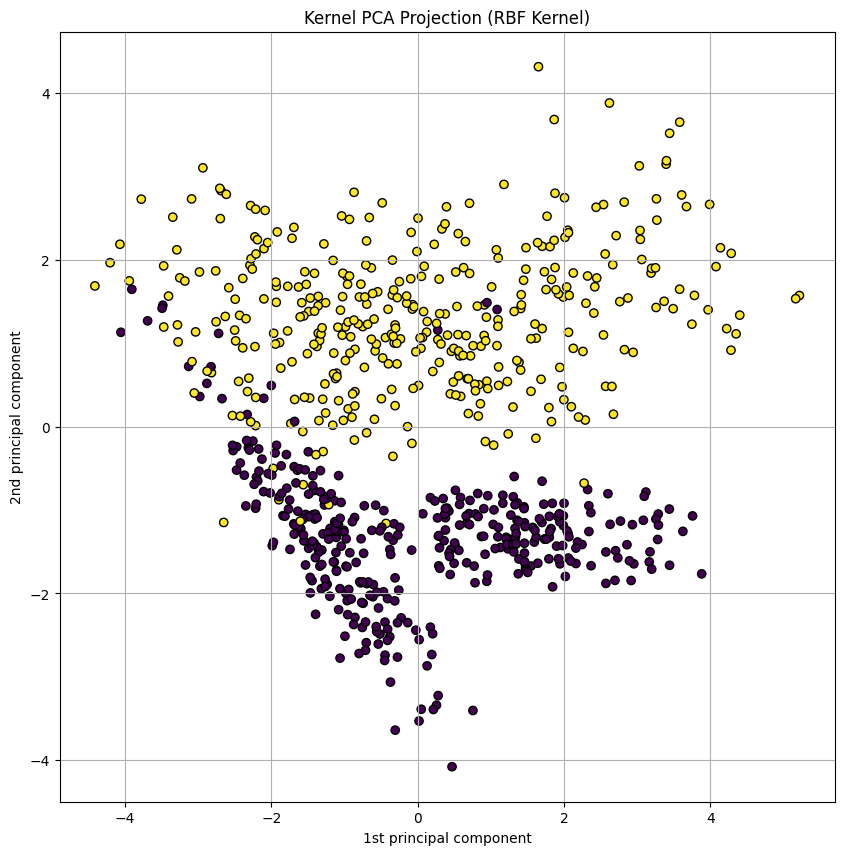

In [43]:
plt.figure(figsize=(10,10))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', edgecolor='k')
plt.title("Kernel PCA Projection (RBF Kernel)")
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.grid(True)
plt.show()

In [44]:
clf = SVC(kernel="linear")
clf.fit(X_train_kpca, y_train)
y_pred = clf.predict(X_test_kpca)

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       126
           1       0.99      0.98      0.98       124

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250



### KPCA

In [46]:
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.01)

X_train_kpca = kpca.fit_transform(X_train)
X_test_kpca = kpca.transform(X_test)

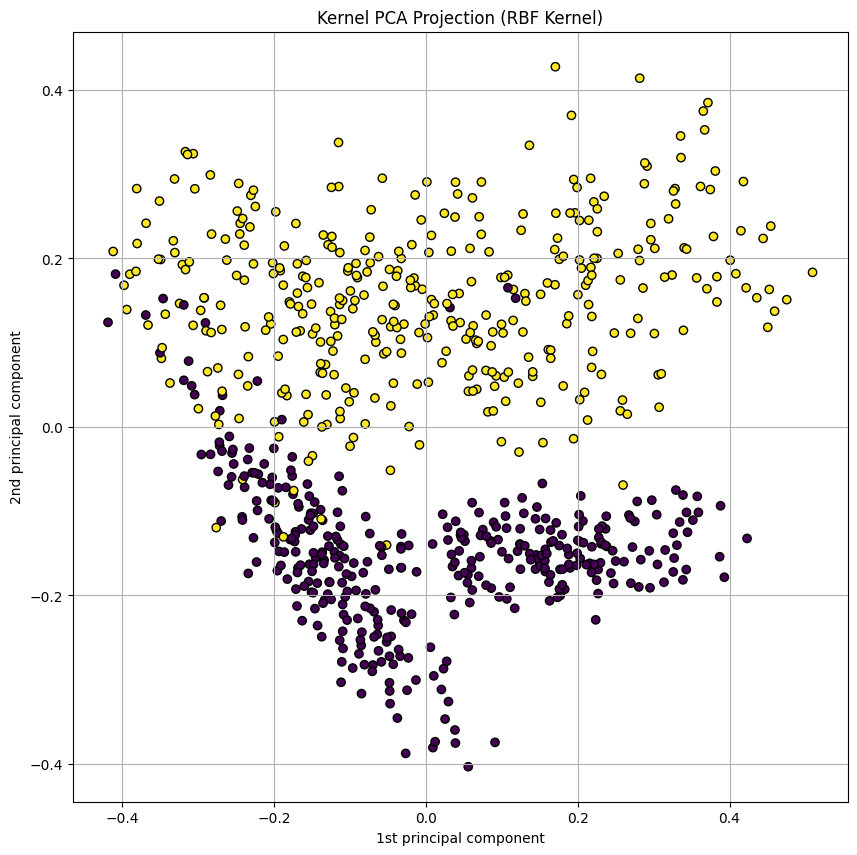

In [47]:
plt.figure(figsize=(10,10))
plt.scatter(X_train_kpca[:, 0], X_train_kpca[:, 1], c=y_train, cmap='viridis', edgecolor='k')
plt.title("Kernel PCA Projection (RBF Kernel)")
plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.grid(True)
plt.show()

In [48]:
clf.fit(X_train_kpca, y_train)
y_pred = clf.predict(X_test_kpca)

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       126
           1       0.95      0.93      0.94       124

    accuracy                           0.94       250
   macro avg       0.94      0.94      0.94       250
weighted avg       0.94      0.94      0.94       250

